In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
import random
import math

In [2]:
def stratifySample(features, labels, bs):
    batches = []
    pos = np.where(labels == 1)[0]
    neg = np.where(labels == 0)[0]
    random.shuffle(pos)
    random.shuffle(neg)

    pos_num = len(pos)
    neg_num = len(neg)

    print("positive:{}\tnegative:{}".format(pos_num, neg_num))

    p_r = pos_num / (neg_num + pos_num)
    n_r = 1-p_r


    bs_p = math.ceil(bs * p_r)
    bs_n = bs - bs_p

    batches_p = math.floor(pos_num/bs_p)
    batches_n = math.floor(neg_num/bs_n)


    for i in range(min(batches_p, batches_n)):
        bt_p_features = features[pos[i*bs_p : (i+1)*bs_p]]
        bt_p_labels = labels[pos[i*bs_p : (i+1)*bs_p]]

        bt_n_features = features[neg[i*bs_n : (i+1)*bs_n]]
        bt_n_labels = labels[neg[i*bs_n : (i+1)*bs_n]]

        bt_comb_features = np.concatenate((bt_p_features, bt_n_features), axis = 0)
        bt_comb_labels = np.concatenate((bt_p_labels, bt_n_labels), axis = 0)

        idx = list(range(bs))
        random.shuffle(idx)
        bt_comb_features, bt_comb_labels = bt_comb_features[idx], bt_comb_labels[idx]
        bt_comb_features, bt_comb_labels = map(torch.tensor, (bt_comb_features, bt_comb_labels))
        batches.append((bt_comb_features, bt_comb_labels))
    return batches

In [3]:
class CBR(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, kernel_size=3):
        super(CBR, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channel)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = nn.functional.relu(x)
        return x
    
class CBR_LargeW(nn.Module):
    def __init__(self, input_channels=3, kernel_size=7, stride=1):
        super(CBR_LargeW, self).__init__()
        self.in_channels = 64
        self.kernel_size = kernel_size
        self.stride = stride
        
        self.CBR1 = CBR(input_channels, self.in_channels, self.stride, self.kernel_size)
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        
        self.CBR2 = CBR(self.in_channels, self.in_channels*2, self.stride, self.kernel_size)
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        
        self.CBR3 = CBR(self.in_channels*2, self.in_channels*4, self.stride, self.kernel_size)
        self.pool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        
        self.CBR4 = CBR(self.in_channels*4, self.in_channels*8, self.stride, self.kernel_size)
        self.pool4 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        
        
        # classifier
        self.fc = nn.Linear(self.in_channels*8, 2)
        
    def forward(self, x):
        x = self.CBR1(x)
        x = self.pool1(x)
        
        x = self.CBR2(x)
        x = self.pool2(x)
        
        x = self.CBR3(x)
        x = self.pool3(x)
        
        x = self.CBR4(x)
        x = self.pool4(x)
        
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [4]:
DATA = np.load("../../../dataset/diabetic-retinopathy-npy/Messidor1/data.npy")
LABEL = np.load("../../../dataset/diabetic-retinopathy-npy/Messidor1/label.npy")
LABEL[LABEL < 3] = 0
LABEL[LABEL >=3 ] = 1


print(DATA.shape, LABEL.shape)
print(np.min(DATA), np.max(DATA))

from collections import Counter

Counter(LABEL)

(700, 224, 224, 3) (700,)
0.0 1.0


Counter({1: 174, 0: 526})

In [5]:
# split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(DATA, LABEL, test_size=0.2, random_state=42)


data = {}
label = {}
data['train'] = X_train
label['train'] = y_train
data['val'] = X_test
label['val'] = y_test

print(X_train.shape, X_test.shape)

(560, 224, 224, 3) (140, 224, 224, 3)


In [6]:
# convert to PIL image
from PIL import Image
from matplotlib import cm


PIL_data = {x:[Image.fromarray(np.uint8(data[x][i] * 255)).convert('RGB') for i in range(data[x].shape[0])] for x in ['train', 'val']}
dataset_sizes = {x: len(PIL_data[x]) for x in ['train', 'val']}

print(dataset_sizes)

{'train': 560, 'val': 140}


In [7]:
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
data_tensor = {x: torch.stack([data_transforms[x](PIL_data[x][i]) for i in range(len(PIL_data[x]))]) for x in ['train', 'val']}
label_tensor = {x: torch.Tensor(label[x]) for x in ['train', 'val']}

In [10]:
ds = TensorDataset(data_tensor['train'], label_tensor['train'])

In [11]:
# ds = {x: TensorDataset(data_tensor[x], label_tensor[x]) for x in ['train', 'val']}
# dl = {x: DataLoader(ds[x], batch_size=32, shuffle=True, num_workers=8) for x in ['train', 'val']}

bs = 8
dl = {x: stratifySample(data_tensor[x], label_tensor[x], bs) for x in ['train', 'val']}

positive:133	negative:427
positive:41	negative:99


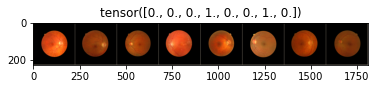

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dl['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)

In [13]:
def my_loss(output, target, criterion):
    
    pos_target = target[target == 1]
    pos_output = output[target == 1]
    
    neg_target = target[target == 0]
    neg_output = output[target == 0]
    
    p_loss = criterion(pos_output, pos_target)/pos_target.shape[0]
    n_loss = criterion(neg_output, neg_target)/neg_target.shape[0]
    
    loss = torch.max(p_loss, n_loss)

    return loss

def train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
            
                    _, preds = torch.max(outputs, 1)
                    loss = my_loss(outputs, labels, criterion)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler != None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
model_ft = CBR_LargeW()
print(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = None

CBR_LargeW(
  (CBR1): CBR(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (CBR2): CBR(
    (conv): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (CBR3): CBR(
    (conv): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (CBR4): CBR(
    (conv): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1))
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool4)

In [15]:
model_ft = train_model(dl, dataset_sizes, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 0.2705 Acc: 0.2554
val Loss: 0.1999 Acc: 0.2786

Epoch 1/99
----------
train Loss: 0.2102 Acc: 0.2429
val Loss: 0.1708 Acc: 0.2714

Epoch 2/99
----------
train Loss: 0.1980 Acc: 0.2411
val Loss: 0.1655 Acc: 0.2714

Epoch 3/99
----------
train Loss: 0.2050 Acc: 0.2518
val Loss: 0.1820 Acc: 0.2929

Epoch 4/99
----------
train Loss: 0.1967 Acc: 0.2446
val Loss: 0.1673 Acc: 0.2857

Epoch 5/99
----------
train Loss: 0.1980 Acc: 0.2536
val Loss: 0.1937 Acc: 0.2786

Epoch 6/99
----------
train Loss: 0.1969 Acc: 0.2786
val Loss: 0.2194 Acc: 0.2786

Epoch 7/99
----------
train Loss: 0.1952 Acc: 0.2589
val Loss: 0.1998 Acc: 0.2786

Epoch 8/99
----------
train Loss: 0.2075 Acc: 0.2679
val Loss: 0.1859 Acc: 0.2929

Epoch 9/99
----------
train Loss: 0.2069 Acc: 0.2661
val Loss: 0.2014 Acc: 0.2786

Epoch 10/99
----------
train Loss: 0.1961 Acc: 0.2857
val Loss: 0.2007 Acc: 0.2786

Epoch 11/99
----------
train Loss: 0.2001 Acc: 0.2804
val Loss: 0.1549 Acc: 0.3429

Ep

train Loss: 0.1454 Acc: 0.5786
val Loss: 0.1959 Acc: 0.3929

Epoch 99/99
----------
train Loss: 0.1463 Acc: 0.5732
val Loss: 0.2044 Acc: 0.5214

Training complete in 10m 12s
Best val Acc: 0.521429


In [16]:
PATH = "saved_models/CBR_LargeW.pt"
torch.save(model_ft.state_dict(), PATH)